https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb

In [ ]:
# ! pip install -Uqq fastbook dotenv duckduckgo_search

In [1]:
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

In [6]:
def search_images_duckduckgo(keyword, max_images=150):
    """
    DuckDuckGo Search for images using duckduckgo_search library
    Can return up to 150 results (library supports unlimited results)
    """
    from duckduckgo_search import DDGS
    
    # Extract image URLs
    image_urls = []
    
    try:
        # Initialize DDGS instance
        ddgs = DDGS()
        
        # Perform image search with max_results=150
        results = ddgs.images(
            keywords=keyword,
            region="wt-wt",  # Worldwide region
            safesearch="moderate",  # Safe search setting
            size=None,  # Any size
            color=None,  # Any color
            type_image=None,  # Any type (photo, clipart, gif, etc.)
            layout=None,  # Any layout
            license_image=None,  # Any license
            max_results=max_images  # Maximum 150 results
        )
        
        # Extract image URLs from results
        for result in results:
            if 'image' in result:
                image_urls.append(result['image'])
        
        print(f"Found {len(image_urls)} image URLs for keyword: {keyword}")
        
    except Exception as e:
        print(f"Error during DuckDuckGo image search: {e}")
    
    return image_urls

# Example usage:
# search_images_duckduckgo("cats")


In [11]:
## Download images (only run once)
bear_types = 'grizzly','black','teddy'
path = Path('images/02')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_duckduckgo(f'{o} bear')
        download_images(dest, urls=results)

In [12]:
# Get image files list
fns = get_image_files(path)
print(f"Total images:{ len(fns) }")
print(f"Sample image path:{fns[:1]}")

Total images:308
Sample image path:[Path('images/02/teddy/48209000-dc9e-4413-b4da-721287243abd.jpg')]


In [13]:
# find and remove any corrupted images
failed = verify_images(fns)
failed

(#0) []

In [14]:
failed.map(Path.unlink)

(#0) []

In [15]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label, # 取得父目錄名稱當作標籤
    item_tfms=Resize(128))

In [16]:
dls = bears.dataloaders(path)

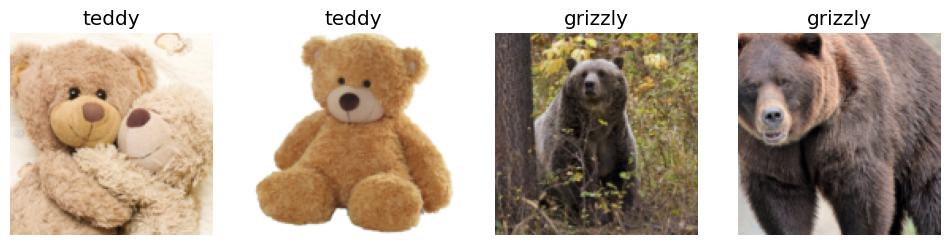

In [10]:
dls.valid.show_batch(max_n=4, nrows=1)

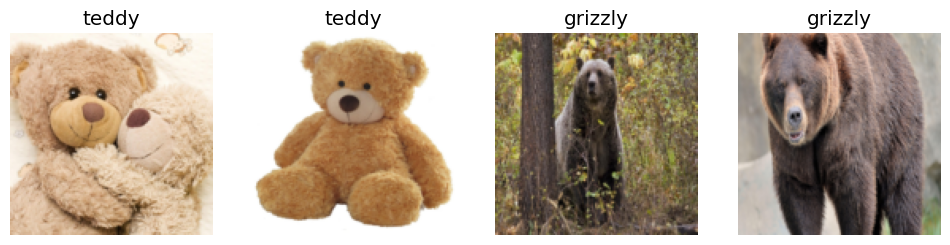

In [11]:
# Try different resizing methods (squish)
# 
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

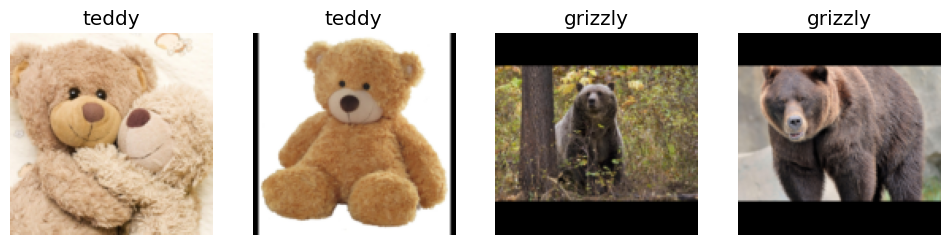

In [12]:
# Try different resizing methods (zeros)
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

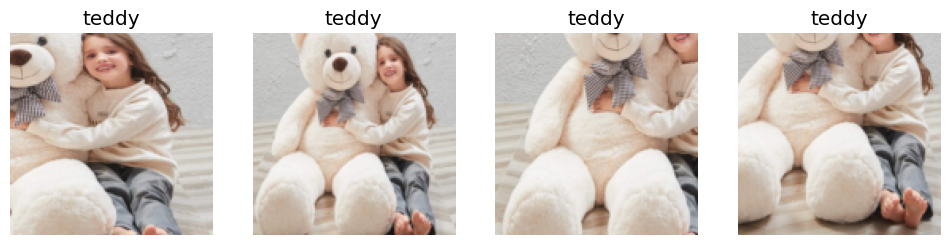

In [13]:
# Try different resizing methods (RandomResizedCrop)
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

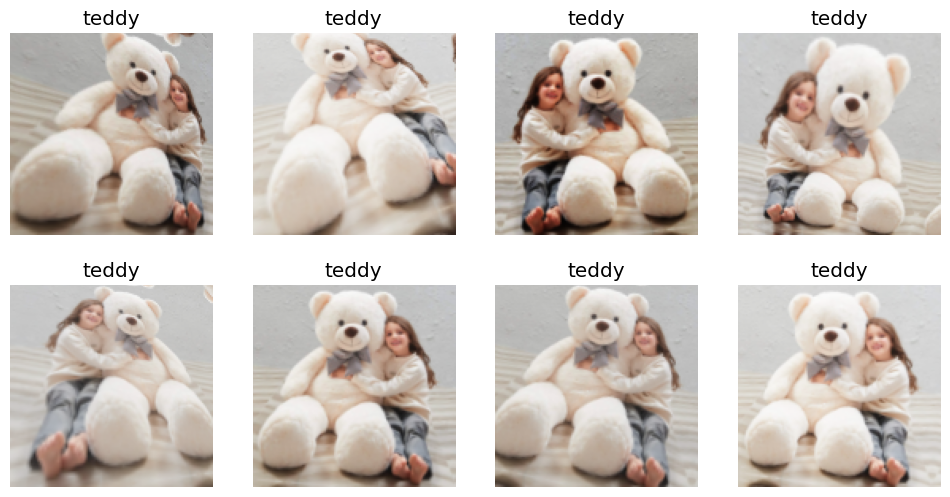

In [14]:
# Data Augmentation
# 參考: https://docs.fast.ai/vision.augment.html
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=1.5))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model

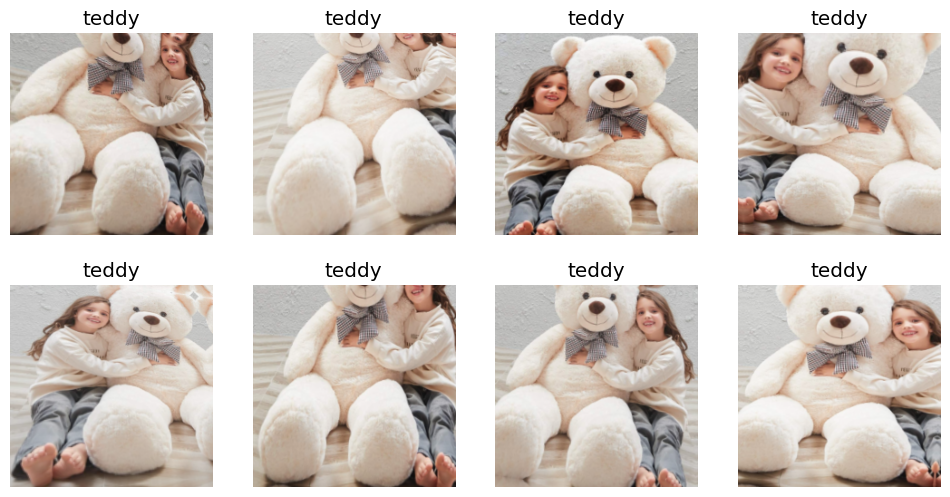

In [17]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.846542,0.323110,0.131148,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.360353,0.117473,0.049180,00:05
1,0.266865,0.064773,0.016393,00:05
2,0.229611,0.064699,0.016393,00:05
3,0.181962,0.059722,0.016393,00:05


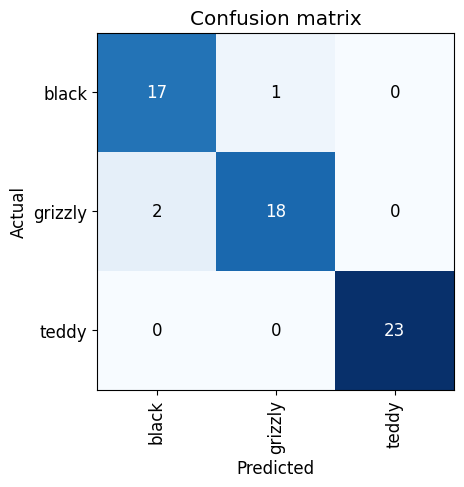

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

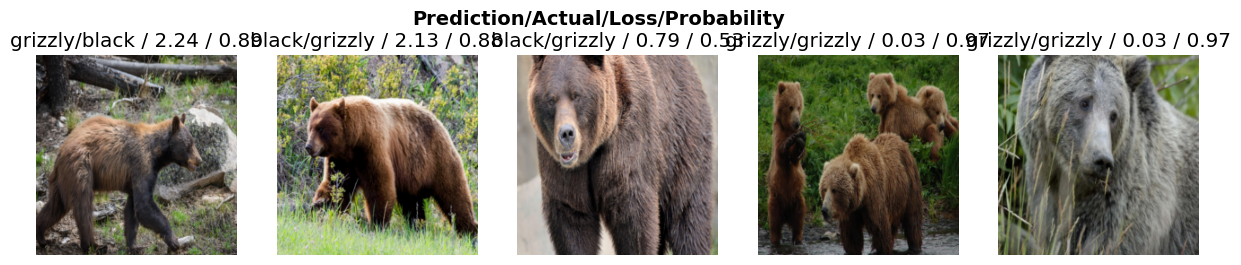

In [18]:
interp.plot_top_losses(5, nrows=1)

In [19]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete():
    file_path = cleaner.fns[idx]
    file_path.unlink()  # 刪除文件
    print(f"已刪除: {file_path}")

In [ ]:
for idx, cat in cleaner.change():
    src_path = cleaner.fns[idx]
    dest_path = path/cat/src_path.name  # 目標路徑
    shutil.move(str(src_path), str(dest_path))
    print(f"已移動: {src_path} -> {dest_path}")

### After clean up the image files, go to above "Training Your Model" again.

## Export and testing the model

In [ ]:
# Export the model
learn.export()

In [ ]:
# Load the model for inference
learn_inf = load_learner('export.pkl')

/home/bellergy/Documents/fastai-notebook/.venv-1/lib/python3.10/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [4]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [5]:
learn_inf.predict('images/02/test/image-01.jpg')

('black', tensor(0), tensor([9.9847e-01, 1.5209e-03, 5.4604e-06]))

In [6]:
learn_inf.predict('images/02/test/image-02.jpg')

('grizzly', tensor(1), tensor([2.3706e-02, 9.7629e-01, 8.8716e-07]))

In [7]:
learn_inf.predict('images/02/test/image-03.jpg')

('teddy', tensor(2), tensor([3.8058e-06, 1.2242e-06, 9.9999e-01]))

## Create UI

In [ ]:
# Upload file using ipywidgets
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
# Load uploaded image
img = PILImage.create(btn_upload.data[-1])

In [11]:
# Preview image
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [14]:
# Prediction
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9991')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [19]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [20]:
btn_upload = widgets.FileUpload()

In [21]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])